# Toy example for the art of t-SNE

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

In [2]:
def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [3]:
nn = [2000, 2000, 2000, 2000, 2000,  1000, 1000, 1000, 1000, 1000,  100, 100, 100, 100, 100]
d1 = [4,   4,   4,   4,   4,    10,  10,  10,  10,  10,   10,  10,  10,  10,  10]
d2 = [20,  20,  20,  20,  20,   20,  20,  20,  20,  20,   20,  20,  20,  20,  20]
cl = [0,   0,   0,   0,   0,    1,   1,   1,   1,   1,    2,   2,   2,   2,   2]

p = 50   # dimensionality

np.random.seed(42)
X = []
y = []

for i,n in enumerate(nn):
    Xpart = np.random.randn(n,p)
    Xpart[:, i] += d1[i]
    Xpart[:,20+cl[i]] += d2[i]
    X.append(Xpart)
    
    ypart = np.ones(n) * i
    y.append(ypart)
          
X = np.concatenate(X)
y = np.concatenate(y)
print('X.shape:', X.shape)
    
pcaInit = PCA(n_components=2).fit_transform(X)
pcaInit = pcaInit / np.std(pcaInit[:,0]) * 0.0001

X.shape: (15500, 50)


In [4]:
%%time

ZZ = []
Z = PCA(n_components=2).fit_transform(X)
ZZ.append(Z)
Z = fast_tsne(X, perplexity=30, seed=42)
ZZ.append(Z)
Z = fast_tsne(X, perplexity=int(X.shape[0]/100), seed=42)
ZZ.append(Z)
Z = fast_tsne(X, perplexity=30, initialization=pcaInit)
ZZ.append(Z)
Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], 
              initialization=pcaInit, learning_rate=X.shape[0]/12)
ZZ.append(Z)

clusterMeans = np.zeros((15, X.shape[1]))
for c in range(15):
    clusterMeans[c,:] = np.mean(X[y==c,:], axis=0)

mds = MDS(2, max_iter=100, n_init=1000, random_state=42)
Zmds = mds.fit_transform(clusterMeans)

CPU times: user 7.03 s, sys: 120 ms, total: 7.15 s
Wall time: 1min 54s


In [5]:
%%time

quality = []
for Z in ZZ:
    a,b,c = embedding_quality(X, Z, y, knn=10, knn_classes=4, subsetsize=1000)
    quality.append((a,b,c))

CPU times: user 53.8 s, sys: 184 ms, total: 54 s
Wall time: 47.9 s


<IPython.core.display.Javascript object>


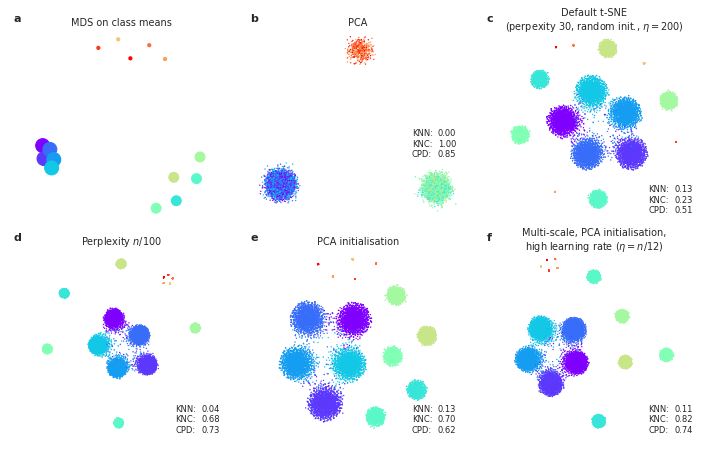

In [6]:
titles = ['MDS on class means', 'PCA', 'Default t-SNE\n(perpexity 30, random init., $\eta=200$)', 'Perplexity $n/100$', 
          'PCA initialisation', 'Multi-scale, PCA initialisation,\nhigh learning rate ($\eta=n/12$)']
letters = 'abcdef'

plt.figure(figsize=(7.2, 4.5))
plt.subplot(231)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Zmds[:,0], Zmds[:,1], s=np.array(nn)/20, c=np.arange(15), cmap='rainbow')
plt.title(titles[0], va='center')
plt.xticks([])
plt.yticks([])
plt.text(0, 1.05, letters[0], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

dy = [0.3,0,0,0,0]
for i,Z in enumerate(ZZ):
    plt.subplot(2,3,2+i)
    plt.gca().set_aspect('equal', adjustable='datalim')
    rand_order = np.random.permutation(Z.shape[0])
    plt.scatter(Z[rand_order,0], Z[rand_order,1], s=1, c=y[rand_order], cmap='rainbow', 
                rasterized=True, edgecolor='none')
    plt.title(titles[i+1], va='center')
    plt.text(0.75,.02+dy[i],'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.87,.02+dy[i],'{:.2f}\n{:.2f}\n{:.2f}'.format(
        quality[i][0], quality[i][1], quality[i][2]), transform=plt.gca().transAxes, fontsize=6)
    plt.text(0, 1.05, letters[i+1], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('figures/toy-simulation.png', dpi=150)
plt.savefig('figures/toy-simulation.pdf', dpi=300)
plt.savefig('figures/toy-simulation-600.pdf', dpi=600)

In [7]:
# High learning rate on its own

Z = fast_tsne(X, perplexity=30, seed=42, learning_rate=X.shape[0]/12)
a,b,c = embedding_quality(X, Z, y, knn=10, knn_classes=4, subsetsize=1000)
print('KNN: {:.2f}\nKNC: {:.2f}\nCPD: {:.2f}'.format(a,b,c))

KNN: 0.17
KNC: 0.45
CPD: 0.60
